## Car Minimum Time

In [1]:
using TrajectoryOptimization
using Plots, LinearAlgebra

┌ Info: Recompiling stale cache file /home/taylor/.julia/compiled/v1.1/TrajectoryOptimization/UVgeA.ji for TrajectoryOptimization [c79d492b-0548-5874-b488-5a62c1d9d0ca]
└ @ Base loading.jl:1184


Import the car model

In [2]:
model = Dynamics.car_model
n = model.n # number of states
m = model.m; # number of control

Define numerical type

In [3]:
T = Float64;

Define initial and goals states

In [4]:
x0 = [0.0;0.0;0.0]
xf = [0.0;1.0;0.0];

Define a cost function, e.g., quadratic

In [5]:
Qf = 100.0*Diagonal(I,n)
Q = (1e-2)*Diagonal(I,n)
R = (1e-2)*Diagonal(I,m)
cost = LQRCost(Q,R,Qf,xf);

Define constraints

In [6]:
u_bnd = 2.
bnd = BoundConstraint(n,m,u_min=-u_bnd,u_max=u_bnd,trim=true)

goal_con = goal_constraint(xf)

con = [bnd, goal_con];

Set options

In [7]:
verbose=false
opts_ilqr = iLQRSolverOptions{T}(verbose=false,live_plotting=:off)

opts_al = AugmentedLagrangianSolverOptions{T}(verbose=false,opts_uncon=opts_ilqr,
    iterations=30,penalty_scaling=10.0)

opts_altro = ALTROSolverOptions{T}(verbose=false,opts_al=opts_al,R_minimum_time=15.0,
    dt_max=0.2,dt_min=1.0e-3);

Define a problem

In [8]:
N = 51
tf = 3.0
U = [ones(m) for k = 1:N-1]
dt = 0.06
obj = Objective(cost,N)
constraints = Constraints(con,N)

prob = Problem(model,obj,integration=:rk4,constraints=constraints,dt=dt,N=N,x0=x0)
initial_controls!(prob, U);

Solve problem

In [9]:
solve!(prob, opts_altro) # solve with ALTRO

Define minimum time problem setting tf to :min

In [10]:
U = [ones(m) for k = 1:N-1]

prob_mt = Problem(model,obj,constraints=constraints,integration=:rk4,
    dt=dt,x0=x0,N=N,tf=:min);
initial_controls!(prob_mt, U);

Solve minimum time problem

In [11]:
solve!(prob_mt, opts_altro); # solve with ALTRO

┌ Info: Minimum Time Solve
└ @ TrajectoryOptimization /home/taylor/.julia/dev/TrajectoryOptimization/src/altro.jl:70


Plot state trajectories

In [12]:
x = [prob.X[k][1] for k = 1:N]
y = [prob.X[k][2] for k = 1:N]

x_min_time = [prob_mt.X[k][1] for k = 1:N]
y_min_time = [prob_mt.X[k][2] for k = 1:N];

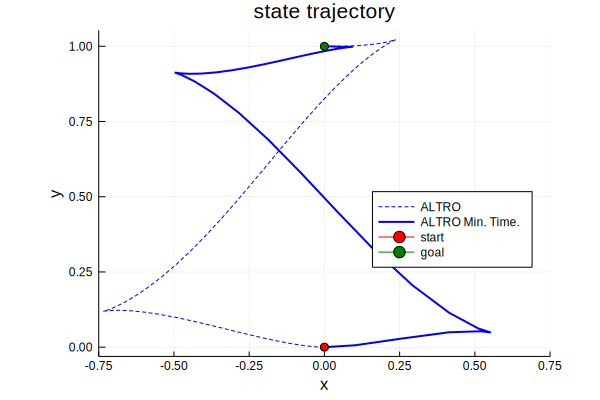

In [13]:
plot()
# plot_obstacles(circles,:orange)
plot!(x,y,xlabel="x",ylabel="y",label="ALTRO",legend=:right,color=:blue,linestyle=:dash,ratio=:equal,title="state trajectory")
plot!(x_min_time,y_min_time,xlim=(-0.75,0.75),xlabel="x",ylabel="y",label="ALTRO Min. Time.",color=:blue,width=2,ratio=:equal,title="state trajectory")

plot!((x[1],y[1]),marker=:circle,color=:red,label="start")
plot!((x[end],y[end]),marker=:circle,color=:green,label="goal")

Compute total time

In [14]:
tt = total_time(prob)
tt_mt = total_time(prob_mt)

9.94985315821436

Plot control trajectories

In [15]:
t_range = range(0, stop=tt, length=N)[1:end-1]
u1 = [prob.U[k][1] for k = 1:N-1]
u2 = [prob.U[k][2] for k = 1:N-1];

In [16]:
t_range_mt = range(0, stop=tt_mt, length=N)[1:end-1]
u1_mt = [prob_mt.U[k][1] for k = 1:N-1]
u2_mt = [prob_mt.U[k][2] for k = 1:N-1];

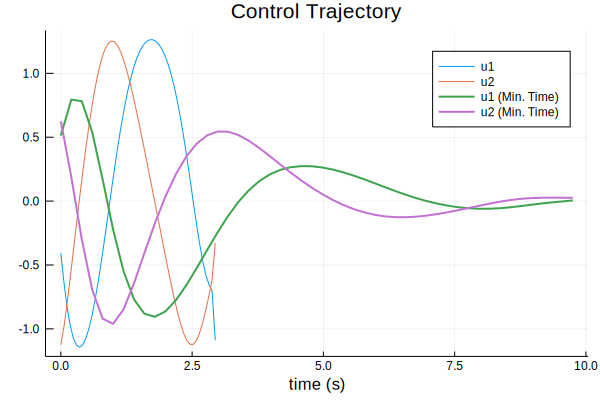

In [17]:
plot(title="Control Trajectory",xlabel="time (s)")
plot!(t_range,u1,label="u1")
plot!(t_range,u2,label="u2")
plot!(t_range_mt,u1_mt,width=2,label="u1 (Min. Time)")
plot!(t_range_mt,u2_mt,width=2,label="u2 (Min. Time)")